# **Test 2 - CSCI 4341 – Big Data Analytics**

**Name: Zobayer Md Ahsanul Mahbub**

**Matric No:2125129**

Email ID: zobayerlabib9671@gmail.com  


In [29]:
#Install PySpark
!pip install -q pyspark

# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

#Import required libraries
from pyspark.sql  import SparkSession
from pyspark.sql.functions import  col,count, when

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
#new Spark session
spark = SparkSession.builder.appName("DeveloperSurveyAnalysis").getOrCreate()

# Loading the dataset from Google Drive
df = spark.read.csv('/content/drive/MyDrive/dataset/devsdd.csv',header=True, inferSchema=True)

# sample records show
df.show(5)

# Print schema
df.printSchema()

# Count total records and features
print(f"Rows: {df.count()}, Columns: {len(df.columns)}")

# Show missing values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Show statistics summary
df.select("Age","WorkWeekHrs", "ConvertedComp", "CompTotal").describe().show()

+----------+--------------------+--------+--------------------+--------------------+------------------+--------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+---------+----------+----------------+------------------+--------------------+------------------+--------+--------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------+--------------------+---------+--------+-------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----------+--------------------+-----+-----------+--------------------+----------+----------+--------------------+--------------------+--------------------+--------------------+-------------+---------+--------------------+--------------------+----------------

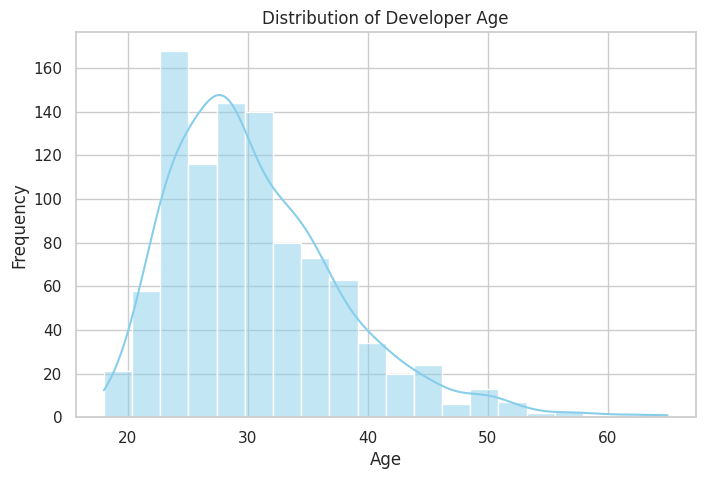

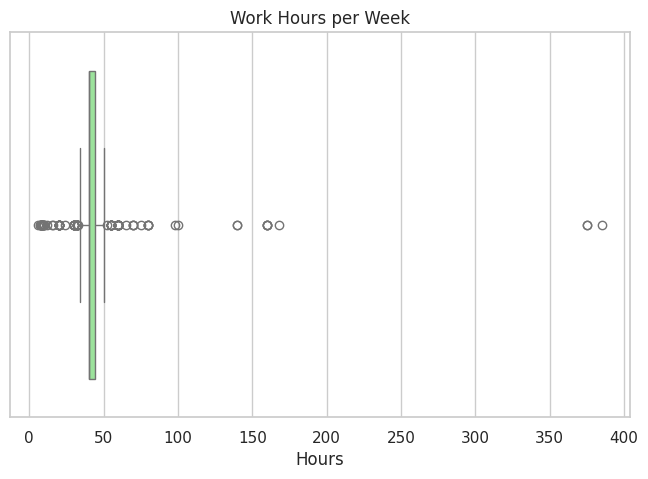

<ipython-input-31-2640482456>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")


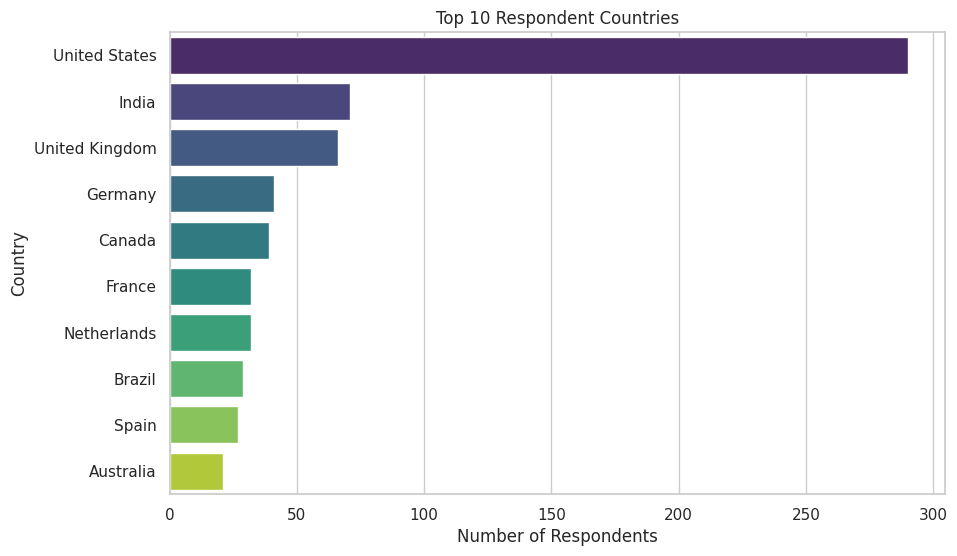

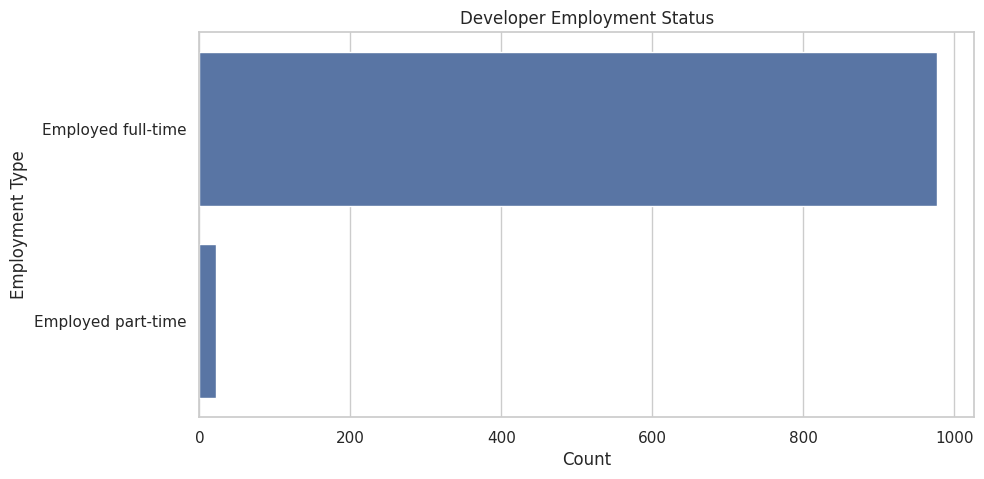

In [31]:
#Convert Spark DataFrame to Pandas sample
df_sample = df.limit(1000).toPandas()

# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# plot Age Distribution
plt.figure(figsize=(8,5))
sns.histplot(df_sample["Age"].dropna(),kde=True, bins=20, color='skyblue')
plt.title("Distribution of Developer Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

#Plot Work Hours per Week
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_sample["WorkWeekHrs"].dropna(),color='lightgreen')
plt.title("Work Hours per Week")
plt.xlabel("Hours")
plt.show()

# Plot Top 10 Countries
top_countries = df_sample["Country"].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")
plt.title("Top 10 Respondent Countries")
plt.xlabel("Number of Respondents")
plt.ylabel("Country")

# employment type
plt.show()
plt.figure(figsize=(10,5))
sns.countplot(data=df_sample,y="Employment", order=df_sample["Employment"].value_counts().index)
plt.title("Developer Employment Status")
plt.xlabel("Count")
plt.ylabel("Employment Type")
plt.show()

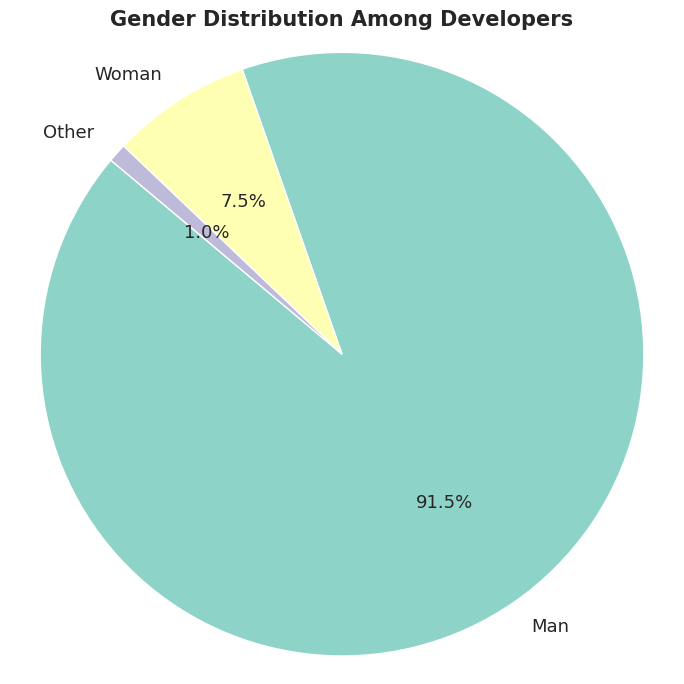

In [32]:
# Clean gender data
gender_clean = df_sample["Gender"].dropna()
gender_clean = gender_clean[~gender_clean.str.lower().str.contains("prefer")]

#count and group small categories
gender_counts = gender_clean.value_counts()
main_genders =gender_counts[gender_counts > 30]
others = gender_counts[gender_counts <= 30].sum()
gender_final= pd.concat([main_genders,pd.Series({'Other': others})])

# Plot pie chart
plt.figure(figsize=(7, 7))
colors = plt.get_cmap('Set3').colors
plt.pie(gender_final,
        labels=gender_final.index,
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 13},
        colors=colors)
plt.title("Gender Distribution Among Developers",fontsize=15, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()


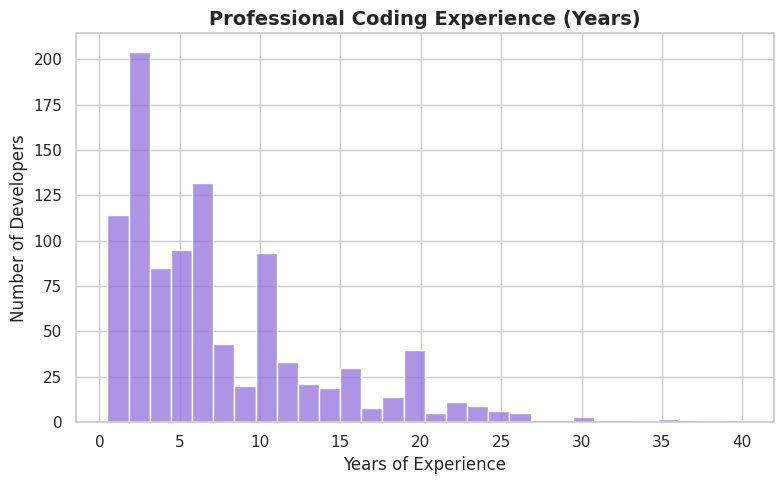

In [33]:
exp = df_sample["YearsCodePro"].dropna().replace({
    'Less than 1 year': 0.5,
    'More than 50 years': 51})

#convert to numeric
exp = pd.to_numeric(exp,errors='coerce').dropna()

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(exp, bins=30, kde=False, color='mediumpurple')
plt.title("Professional Coding Experience (Years)", fontsize=14,fontweight='bold')
plt.xlabel("Years of Experience")
plt.ylabel("Number of Developers")
plt.tight_layout()
plt.show()

In [34]:
# drop missing values in Employment column
employment_data = df_sample["Employment"].dropna()

#count values and convert it to percentage
employment_percent = employment_data.value_counts(normalize=True) * 100

# rounding up to 1 decimal
employment_percent = employment_percent.round(1)
print(employment_percent)


Employment
Employed full-time    97.8
Employed part-time     2.2
Name: proportion, dtype: float64


+--------------------+-------------+-----------+--------------------+--------------------+
|              JobSat|ConvertedComp|WorkWeekHrs|          WorkRemote|             OrgSize|
+--------------------+-------------+-----------+--------------------+--------------------+
|  Slightly satisfied|        61000|       80.0|Less than once pe...|100 to 499 employees|
|  Slightly satisfied|        95179|       32.0|Less than once pe...|  10 to 19 employees|
|      Very satisfied|        90000|       40.0|All or almost all...|  10 to 19 employees|
|  Slightly satisfied|       455352|       40.0|A few days each m...|100 to 499 employees|
|Neither satisfied...|        65277|       45.0|A few days each m...|  20 to 99 employees|
+--------------------+-------------+-----------+--------------------+--------------------+
only showing top 5 rows

+--------------------+-----+
|              JobSat|count|
+--------------------+-----+
|  Slightly satisfied| 3633|
|      Very satisfied| 3279|
|Slightly d

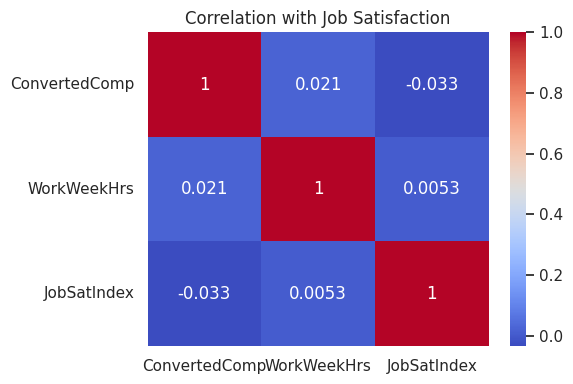

In [35]:
#DS1-What factors influence a developer’s job satisfaction?

#Selecting the relevant columns
cols = ["JobSat", "ConvertedComp", "WorkWeekHrs", "WorkRemote", "OrgSize"]
job_df = df.select(cols)

# Drop missing values
job_df = job_df.dropna()

# display some rows
job_df.show(5)

#job satisfaction levels count
job_df.groupBy("JobSat").count().orderBy("count",ascending=False).show()

# Converting JobSat to numeric
from pyspark.ml.feature import StringIndexer
indexer= StringIndexer(inputCol="JobSat",outputCol="JobSatIndex")
job_df =indexer.fit(job_df).transform(job_df)

# Selecting numeric columns for correlation
numeric_df = job_df.select("ConvertedComp","WorkWeekHrs", "JobSatIndex")
# convert to pandas for correlation and plotting
correlation_df =  numeric_df.toPandas()

# Correlation matrix draw
print(correlation_df.corr())

#plot of heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation with Job Satisfaction")
plt.tight_layout()
plt.show()


In [36]:
#DS2- Can we predict a developer’s compensation based on their experience, education, and country?

#Select possible columns
cols = ["ConvertedComp", "YearsCodePro", "EdLevel", "Country"]
salary_df = df.select(cols).dropna()

#Replace the string values in YearsCodePro
salary_df =salary_df.replace("Less than 1 year","0.5", subset=["YearsCodePro"])
salary_df = salary_df.replace("More than 50 years", "51", subset=["YearsCodePro"])

#Converting YearsCodePro to numeric
from pyspark.sql.functions import col
salary_df = salary_df.withColumn("YearsCodePro",col("YearsCodePro").cast("double"))

# categorical features
from pyspark.ml.feature import StringIndexer

ed_indexer =StringIndexer(inputCol="EdLevel", outputCol="EdLevelIndex")
ct_indexer = StringIndexer(inputCol="Country", outputCol="CountryIndex")
salary_df= ed_indexer.fit(salary_df).transform(salary_df)
salary_df =ct_indexer.fit(salary_df).transform(salary_df)

# Prepare features
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["YearsCodePro", "EdLevelIndex", "CountryIndex"],
    outputCol="features")
salary_model_df = assembler.transform(salary_df).select("features", "ConvertedComp")

#train-test split
train_data, test_data = salary_model_df.randomSplit([0.8, 0.2], seed=42)

#train linear regression model
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol="ConvertedComp", featuresCol="features")
lr_model = lr.fit(train_data)

#evaluation on test data
test_results = lr_model.evaluate(test_data)

print(f"RMSE: {test_results.rootMeanSquaredError:.2f}")
print(f"R²: {test_results.r2:.2f}")


RMSE: 287771.31
R²: 0.03


In [37]:
#DS2-continue
cols = ["ConvertedComp", "YearsCodePro", "EdLevel", "Country", "OrgSize", "JobSeek"]
data = df.select(cols).dropna()

#clean YearsCodePro feature
data= data.replace("Less than 1 year", "0.5", subset=["YearsCodePro"])
data = data.replace("More than 50 years", "51", subset=["YearsCodePro"])
from pyspark.sql.functions import col
data =data.withColumn("YearsCodePro", col("YearsCodePro").cast("double"))

#encode categorical features
from pyspark.ml.feature import StringIndexer

indexers = [
    StringIndexer(inputCol="EdLevel", outputCol="EdLevelIndex"),
    StringIndexer(inputCol="Country", outputCol="CountryIndex"),
    StringIndexer(inputCol="OrgSize", outputCol="OrgSizeIndex"),
    StringIndexer(inputCol="JobSeek", outputCol="JobSeekIndex")]

for indexer in indexers:
    data = indexer.fit(data).transform(data)

#Assemble features
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["YearsCodePro", "EdLevelIndex", "CountryIndex", "OrgSizeIndex", "JobSeekIndex"],
    outputCol="features")

final_df = assembler.transform(data).select("features", "ConvertedComp")

# Train-test split
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)

# train decision tree rgressor with increased maxBins
from pyspark.ml.regression import DecisionTreeRegressor

dt= DecisionTreeRegressor(labelCol="ConvertedComp", featuresCol="features", maxBins=150)
dt_model = dt.fit(train_data)

# Predict and evaluate
predictions = dt_model.transform(test_data)

from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="ConvertedComp", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2 = RegressionEvaluator(labelCol="ConvertedComp", predictionCol="prediction", metricName="r2").evaluate(predictions)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


RMSE: 282115.31
R²: 0.05


+--------------------+-----------------+
|             Country|   AvgWorkWeekHrs|
+--------------------+-----------------+
|             Finland|86.25357142857143|
|              Norway| 84.7202380952381|
|             Burundi|             77.0|
|           Sri Lanka|            65.15|
|             Austria|62.45977011494253|
|          Kyrgyzstan|            60.25|
|               Qatar|             60.0|
|             Senegal|             55.0|
|      Czech Republic|52.11594202898551|
|Venezuela, Boliva...|50.42857142857143|
+--------------------+-----------------+
only showing top 10 rows

+-----------+--------------------+-----+
|    Country|          WorkRemote|count|
+-----------+--------------------+-----+
|Afghanistan|Less than once pe...|    2|
|    Albania|Less than half th...|    3|
|    Albania| About half the time|    1|
|    Albania|All or almost all...|    2|
|    Albania|Less than once pe...|    6|
|    Algeria|Less than once pe...|    1|
|    Algeria|All or almost all.

<ipython-input-38-846761966>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Country", x="AvgWorkWeekHrs", data=top_hours_pd, palette="crest")


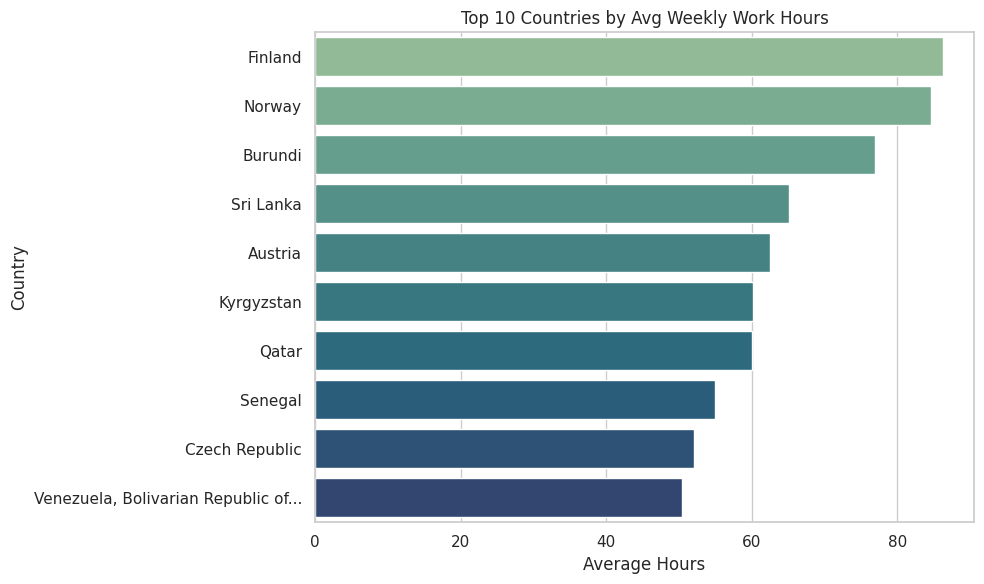

In [38]:
# DS3 - Are there noticeable differences in work patterns across countries?

# select necessary columns
work_df = df.select("Country", "WorkWeekHrs", "WorkRemote").dropna()

# average work hours by country
avg_hours = work_df.groupBy("Country").avg("WorkWeekHrs").withColumnRenamed("avg(WorkWeekHrs)", "AvgWorkWeekHrs")
avg_hours = avg_hours.orderBy("AvgWorkWeekHrs", ascending=False)
# display top 10 countries with highest average work hours
avg_hours.show(10)

# Count remote work types baced on country
remote_count =work_df.groupBy("Country", "WorkRemote").count().orderBy("Country")
remote_count.show(10)

#Visualise top 10 countries
top_hours_pd = avg_hours.limit(10).toPandas()

# Plot average work hours by country
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(y="Country", x="AvgWorkWeekHrs", data=top_hours_pd, palette="crest")
plt.title("Top 10 Countries by Avg Weekly Work Hours")
plt.xlabel("Average Hours")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


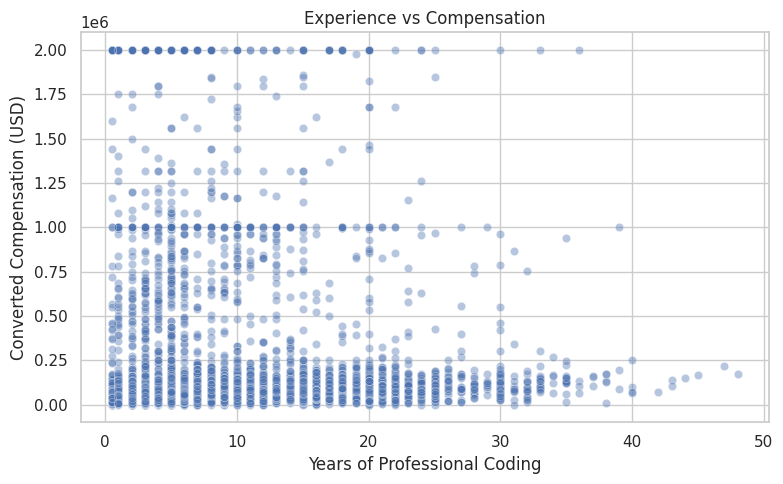

<ipython-input-39-3786182821>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=exp_pd, x="JobSatIndex", y="YearsCodePro", palette="coolwarm")


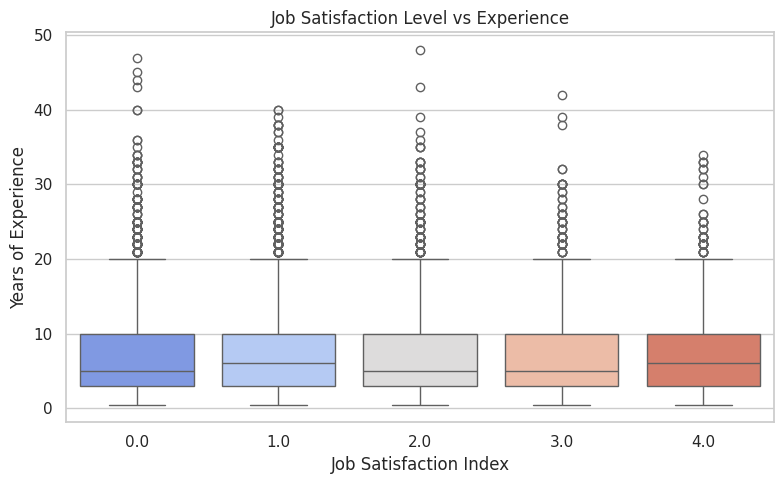

In [39]:
# DS 4 - How does professional coding experience relate to job satisfaction and compensation
# Select and clean data
cols =["YearsCodePro", "JobSat", "ConvertedComp"]
exp_df = df.select(cols).dropna()

exp_df =exp_df.replace("Less than 1 year","0.5",subset=["YearsCodePro"])
exp_df= exp_df.replace("More than 50 years", "51", subset=["YearsCodePro"])
from pyspark.sql.functions import col
exp_df = exp_df.withColumn("YearsCodePro",col("YearsCodePro").cast("double"))

#JobSat encodeing
from pyspark.ml.feature import StringIndexer
indexer= StringIndexer(inputCol="JobSat", outputCol="JobSatIndex")
exp_df =indexer.fit(exp_df).transform(exp_df)

#Convert to pandas
exp_pd = exp_df.select("YearsCodePro","ConvertedComp", "JobSatIndex").toPandas()

# Plot experience vs compensation
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.scatterplot(data=exp_pd, x="YearsCodePro", y="ConvertedComp", alpha=0.4)
plt.title("Experience vs Compensation")
plt.xlabel("Years of Professional Coding")
plt.ylabel("Converted Compensation (USD)")
plt.tight_layout()
plt.show()

#Plot experience vs job satisfaction
plt.figure(figsize=(8, 5))
sns.boxplot(data=exp_pd, x="JobSatIndex", y="YearsCodePro", palette="coolwarm")
plt.title("Job Satisfaction Level vs Experience")
plt.xlabel("Job Satisfaction Index")
plt.ylabel("Years of Experience")
plt.tight_layout()
plt.show()


In [40]:
#DS5 - Can we group developers into cluster based on their experience compensation and work habit?
#selection of relevant columns
cluster_df= df.select("YearsCodePro", "ConvertedComp","WorkWeekHrs").dropna()
cluster_df = cluster_df.replace("Less than 1 year", "0.5",subset=["YearsCodePro"])
cluster_df =cluster_df.replace("More than 50 years", "51", subset=["YearsCodePro"])
from pyspark.sql.functions import col
cluster_df = cluster_df.withColumn("YearsCodePro", col("YearsCodePro").cast("double"))

# assemble features
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols=["YearsCodePro", "ConvertedComp", "WorkWeekHrs"],
    outputCol="features")
cluster_data = assembler.transform(cluster_df).select("features")

# Apply K-Means clustering
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=4, seed=1)
model = kmeans.fit(cluster_data)

# cluster predictions
clustered = model.transform(cluster_data)
clustered.show(5)


+-------------------+----------+
|           features|prediction|
+-------------------+----------+
| [0.5,61000.0,80.0]|         1|
| [4.0,95179.0,32.0]|         1|
| [8.0,90000.0,40.0]|         1|
|[3.0,455352.0,40.0]|         0|
| [2.0,65277.0,45.0]|         1|
+-------------------+----------+
only showing top 5 rows



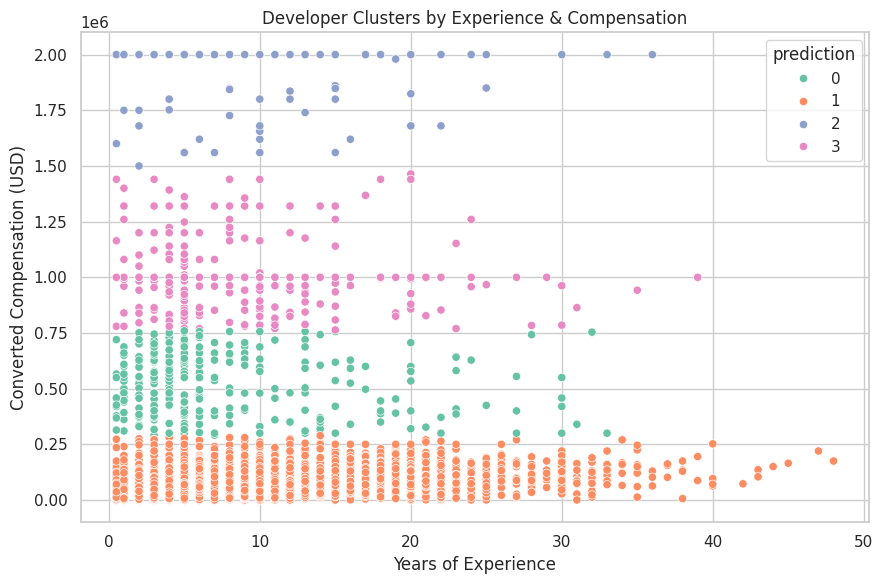

In [41]:
#convert to pandas
cluster_pd = clustered.select("features", "prediction").toPandas()

#split features into columns
import pandas as pd
cluster_pd[["YearsCodePro", "ConvertedComp", "WorkWeekHrs"]] = pd.DataFrame(
    cluster_pd["features"].tolist(), index=cluster_pd.index)

# Plot of clusters
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=cluster_pd,
    x="YearsCodePro",
    y="ConvertedComp",
    hue="prediction",
    palette="Set2")
plt.title("Developer Clusters by Experience & Compensation")
plt.xlabel("Years of Experience")
plt.ylabel("Converted Compensation (USD)")
plt.tight_layout()
plt.show()
